# Heatmap LRP

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import tensorflow as tf

In [2]:
import sys
from pathlib import Path
import_path = str(Path(os.getcwd()).parent.parent)
sys.path.insert(0, import_path)

from WorldModelsExperiments.breakout.model import Model, make_model

In [3]:
path = '/home/dakaun/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200420'
rnn_path = path + '/tf_rnn/rnn.json'
vae_path = path + '/tf_vae/vae.json'
controller_path = path + '/log/breakout.cma.16.32.best.json'

render_mode = False
use_model = True

model = make_model(rnn_path=rnn_path, vae_path=vae_path)
model.load_model(controller_path)

INFO:tensorflow:Model using cpu.
loading file /home/dakaun/Dropbox/MA/worldmodel/worldmodel-breakout-server-version-v3/200420/log/breakout.cma.16.32.best.json


In [ ]:
obs = model.env.reset()
obs = _process_frame(obs)
z, mu, logvar = model.encode_obs(obs)

In [ ]:
model.weight.shape

In [ ]:
h = np.concatenate([z, model.state.h[0]])
h.shape

In [7]:
np.matmul(h, model.weight)

array([ 0.8562,  4.4856, -2.2865,  4.3942])

In [8]:
model.weight.max()

2.0527

In [9]:
model.weight.min()

-1.6984

In [7]:
INPUT_SHAPE = (64,64)
def _process_frame(frame): # converts into (64,64,3)
    img = Image.fromarray(frame)
    img = img.resize(INPUT_SHAPE)#.convert('L')  # resize
    obs = np.array(img)
    obs = obs / 255.
    return obs

In [5]:
def simulate(model, train_mode=False, render_mode=True, num_episode=5, seed=-1, max_len=-1):
    reward_list = []
    t_list = []
    max_episode_length = 10
    tsne_data = pd.DataFrame()    
    action_list = []#action_list_episode = []
    observation_list_episode = []
    reward_target = []
    
    if (seed >= 0):
        random.seed(seed)
        np.random.seed(seed)
        model.env.seed(seed)
    

    for episode in range(num_episode):
        #action_list = []
        observation_list = []
        obs = model.env.reset()
        if obs is None:
            obs = deepcopy(model.env.reset())
        #obs = _process_frame(obs)

        total_reward = 0.0

        for t in range(max_episode_length):
            if render_mode:
                model.env.render("human")
                model.env.unwrapped.viewer.window.on_key_press = key_press
                if RENDER_DELAY:
                    time.sleep(0.01)
            else:
                model.env.render('rgb_array')
            obs = _process_frame(obs)
            z, mu, logvar = model.encode_obs(obs)
            _, action = model.get_action(z)
            obs, reward, done, info = model.env.step(action)

            action_list.append(int(action))
            #observation_list.append(obs)
            #obs = _process_frame(obs)
            total_reward += reward
            #reward_target.append(int(reward))
            
            data = np.concatenate([z, model.state.h[0]]).reshape(1,288)
            #data = np.append(data, action).reshape(1,289)
            tsne_data = tsne_data.append(pd.DataFrame(data), ignore_index=True)

            if done:
                if render_mode:
                    model.env.close()
                #action_list_episode.append(np.array(action_list))
                #observation_list_episode.append(observation_list)
                break
        if render_mode:
            print("reward", total_reward, "timesteps", t)
        #reward_list.append(total_reward)
        #t_list.append(t)
    return action_list, tsne_data#, reward_target


In [8]:
actions, xtsne = simulate(model, train_mode=False, render_mode=False, num_episode=1)

In [9]:
actions = np.array(actions)

### only controller

In [225]:
xtsne = np.array(xtsne)
xtsne.shape

(476, 288)

In [226]:
model.weight.shape

(288, 4)

In [245]:
L_cont = 1

In [246]:
A_cont = [xtsne] + [None]*L_cont
A_cont[1] = np.maximum(0,A_cont[0].dot(model.weight)+model.bias)

In [247]:
A_cont[1][0].shape

(4,)

In [248]:
R_cont= [None]*L + [A_cont[L]*(actions[:,None]==np.arange(4))]

In [249]:
w = model.weight
wp = np.maximum(0,w)
wm = np.minimum(0,w)
lb = A_cont[0]*0-1
hb = A_cont[0]*0+1

z = A_cont[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R_cont[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R_cont[0] = A_cont[0]*c-lb*cp-hb*cm

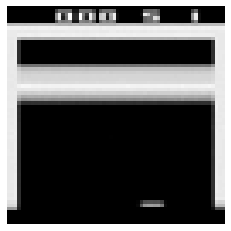

In [237]:
img = (model.vae.decode(xtsne[0,:32].reshape(1,32)).reshape(64,64,3))*255.
img = Image.fromarray(img.astype('uint8')).convert('L')
img = np.array(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show()

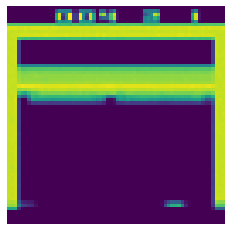

In [238]:
img_r = (model.vae.decode(R_cont[0][300,:32].reshape(1,32)).reshape(64,64,3))*255.
img_r = Image.fromarray(img_r.astype('uint8')).convert('L')
img_r = np.array(img_r)
plt.imshow(img_r)
plt.axis('off')
plt.show()

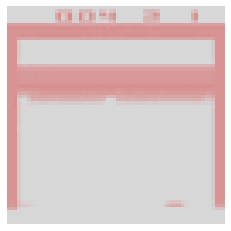

In [250]:
b = 10*((np.abs(img_r)**3.0).mean()**(1.0/3))

from matplotlib.colors import ListedColormap
my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)
plt.imshow(img_r, cmap=my_cmap, vmin=-b, vmax=b)
plt.axis('off')
plt.show()

Combination of Controller and Decoder

Prepare data and weights

In [10]:
xtsne = np.array(xtsne)
xtsne.shape

(10, 288)

In [15]:
X = model.vae.decode(xtsne[0:1,:32])
X.shape

(1, 64, 64, 3)

In [17]:
T = actions[0]
T

1

In [18]:
model.weight.shape

(288, 4)

In [21]:
vaekernel_params = []
vaebias_params = []
vaelayerkernel_names = []
vaelayerbias_names = []
with model.vae.g.as_default():
    t_vars = tf.trainable_variables()
    for var in t_vars:
        if var.name.startswith('dec_'):
            layername = var.name
            print(var)
            p = model.vae.sess.run(var)
            if 'kernel' in layername:
                vaekernel_params.append(p)
                vaelayerkernel_names.append(layername)
            elif 'bias' in layername:
                vaebias_params.append(p)
                vaelayerbias_names.append(layername)
            #params = np.round(p*10000).astype(np.int).tolist()

<tf.Variable 'dec_fc/kernel:0' shape=(32, 1024) dtype=float32_ref>
<tf.Variable 'dec_fc/bias:0' shape=(1024,) dtype=float32_ref>
<tf.Variable 'dec_deconv1/kernel:0' shape=(5, 5, 128, 1024) dtype=float32_ref>
<tf.Variable 'dec_deconv1/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'dec_deconv2/kernel:0' shape=(5, 5, 64, 128) dtype=float32_ref>
<tf.Variable 'dec_deconv2/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'dec_deconv3/kernel:0' shape=(6, 6, 32, 64) dtype=float32_ref>
<tf.Variable 'dec_deconv3/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'dec_deconv4/kernel:0' shape=(6, 6, 3, 32) dtype=float32_ref>
<tf.Variable 'dec_deconv4/bias:0' shape=(3,) dtype=float32_ref>


In [23]:
with model.vae.g.as_default():
    varss = tf.variable_scope('dec_fc/kernel:0')
varss

In [20]:
for idxk in range(len(vaekernel_params)):
    print(vaelayerkernel_names[idxk])
    print(vaekernel_params[idxk].shape)
print('\n')
for idxb in range(len(vaebias_params)):
    print(vaelayerbias_names[idxb])
    print(vaebias_params[idxb].shape)

dec_fc/kernel:0
(32, 1024)
dec_deconv1/kernel:0
(5, 5, 128, 1024)
dec_deconv2/kernel:0
(5, 5, 64, 128)
dec_deconv3/kernel:0
(6, 6, 32, 64)
dec_deconv4/kernel:0
(6, 6, 3, 32)


dec_fc/bias:0
(1024,)
dec_deconv1/bias:0
(128,)
dec_deconv2/bias:0
(64,)
dec_deconv3/bias:0
(32,)
dec_deconv4/bias:0
(3,)


In [267]:
# W[0] is Pixel Layer und W[-1] action layer
W = vaekernel_params[::-1] + [model.weight]
len(W)

6

In [268]:
B = vaebias_params[::-1] + [model.bias]

In [269]:
L = len(W)

Prepare A

In [270]:
A = [X] + [None]*L

In [273]:
print(A[0].shape)
print(W[0].shape)
print(B[0].shape)

(10, 64, 64, 3)
(6, 6, 3, 32)
(3,)


In [272]:
A[1] = np.maximum(0,A[0].dot(W[0])+B[0])

ValueError: operands could not be broadcast together with shapes (10,64,64,6,6,32) (3,) 

In [216]:
for l in range(L):
    A[l+1]= np.maximum(0,A[l].dot(W[l])+B[l])

ValueError: shapes (476,288) and (6,6,3,32) not aligned: 288 (dim 1) != 3 (dim 2)

In [150]:
A[1]= np.maximum(0,A[0].dot(model.weight)+model.bias)
print(A[0].shape)
print(A[1].shape)

(476, 288)
(476, 4)


In [153]:
R = [None]*L + [A[L]*(actions[:,None]==np.arange(4))]

In [157]:
w = model.weight
wp = np.maximum(0,w)
wm = np.minimum(0,w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R[0] = A[0]*c-lb*cp-hb*cm

In [158]:
print(R[0].shape)
print(R[1].shape)

(476, 288)
(476, 4)


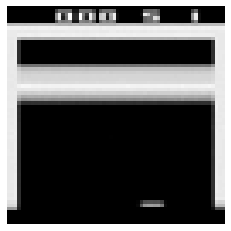

In [164]:
img = (model.vae.decode(xtsne[0,:32].reshape(1,32)).reshape(64,64,3))*255.
img = Image.fromarray(img.astype('uint8')).convert('L')
img = np.array(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show()

R[0][0]

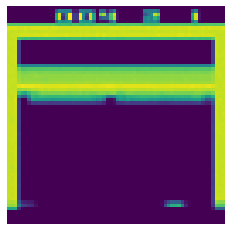

In [167]:
img_r = (model.vae.decode(R[0][300,:32].reshape(1,32)).reshape(64,64,3))*255.
img_r = Image.fromarray(img_r.astype('uint8')).convert('L')
img_r = np.array(img_r)
plt.imshow(img_r)
plt.axis('off')
plt.show()

R[0][50]

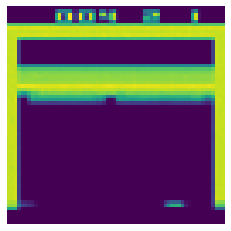

In [141]:
img_r = (model.vae.decode(R[0][700,:32].reshape(1,32)).reshape(64,64,3))*255.
img_r = Image.fromarray(img_r.astype('uint8')).convert('L')
img_r = np.array(img_r)
plt.imshow(img_r)
plt.axis('off')
plt.show()

In [137]:
R[0].shape

(4988, 288)

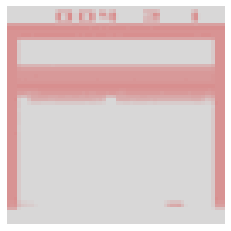

In [133]:
b = 10*((np.abs(img_r)**3.0).mean()**(1.0/3))

from matplotlib.colors import ListedColormap
my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)
plt.imshow(img_r, cmap=my_cmap, vmin=-b, vmax=b)
plt.axis('off')
plt.show()